In [2]:
import netgen.gui
%gui tk 
# Netgen Graphical User Interface
from ngsolve import *
from netgen.geom2d import SplineGeometry
import numpy as np
from scipy import special
import scipy.linalg
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import os.path
import sys
%load_ext autoreload
%autoreload 1
%aimport OpenScatteringSystems2d_funcs
from OpenScatteringSystems2d_funcs import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
nphwl = 5  # nodes per half wavelength
feOrder = 3  # order of finite element polynomials between two nodes
pmlRad = 0.1 # radius of the region under consideration
lam = 0.025 # wavelength (lambda)
k = 2*np.pi/lam # wavevector

# Fix the number of modes by truncation
nOut = 0 # Number of output modes
while np.abs(sp.special.hankel1(nOut,k*pmlRad)) < 1e3: nOut += 1
nIn = nOut # Number of input modes
        
print('Number of modes = %d' %nIn)
print('Radius / lambda = %.1f' %(pmlRad/lam))
print('Circumference / lambda = %.1f' %(2*np.pi*pmlRad/lam))

shifts = np.array([-0.00825, 0.00825, 0.0])/100000.0  # transverse scatterer shifts

# Parameter dictionary to pass to functions
params = {'nphwl': nphwl, 
          'feOrder': feOrder,
          'k': k,
          'pmlRad': pmlRad,
          'nIn': nIn,
          'nOut': nOut,
          'mesh': None,
          'nrefr': None,
          'ainvGlobal': None}

Number of modes = 39
Radius / lambda = 4.0
Circumference / lambda = 25.1


# Empty Geometry

Create the scattering geometry

In [4]:
CreateGeometry(params, msgOutput=True)

MESH number of vertices = 11076


Plot the fundamental mode ($H_0$) and $H_5$

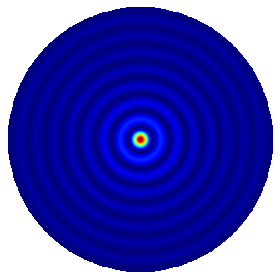

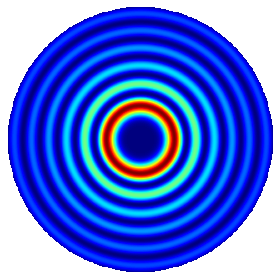

In [5]:
PlotStates(params, np.eye(2*nIn+1), [nIn, nIn+5], widthInches=4)

Compute the scattering matrix

In [6]:
S = CalcSMat(params)

Check that the scattering matrix is unitary and transposition symmetric

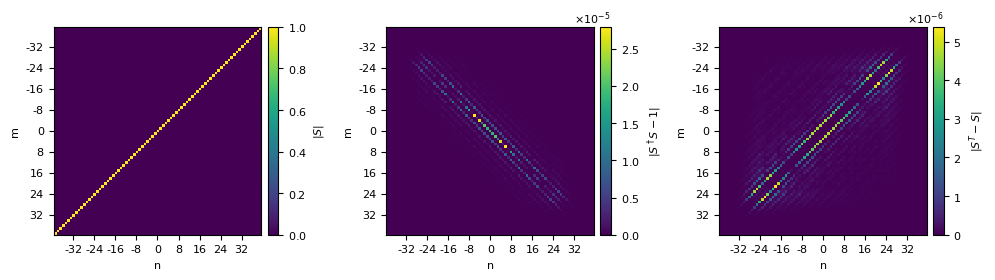

In [7]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

Solve the system

In [9]:
sols = Solve(params, np.eye(2*nIn+1)[:,[nIn,nIn+5]]) # Solves the system for the incoming states H_0 and H_5

FES degrees of freedom = 98644
Using stored inverted system matrix ...


In [14]:
# Points on which to read out the wavefunction
rs = np.linspace(0,pmlRad,200)
phis = np.linspace(0,np.pi/2,7)

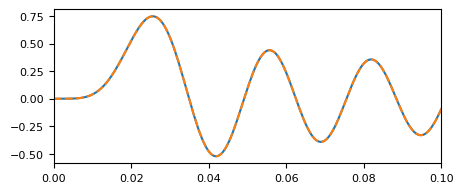

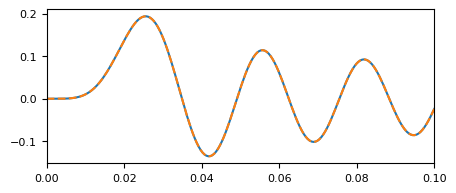

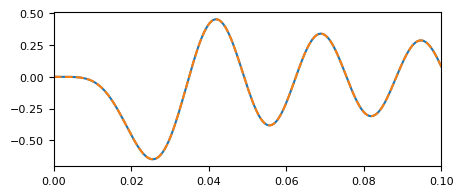

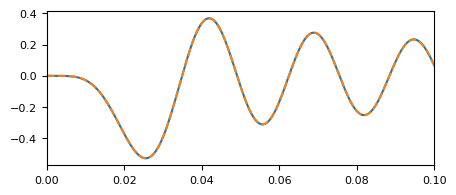

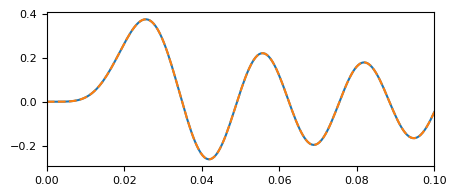

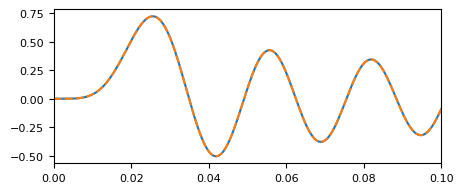

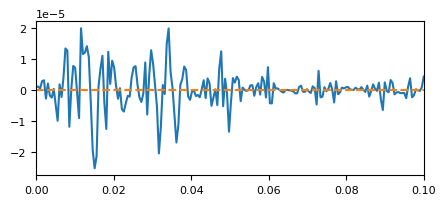

In [15]:
for i in range(len(phis)):
    psi = sols[1](params['mesh'](rs*np.cos(phis[i]),rs*np.sin(phis[i]))) # Read out the solution on a line
    plt.figure(figsize=(5,2))
    plt.plot(rs, np.real(psi))
    plt.plot(rs, 2*sp.special.jn(5,k*rs)*np.real(np.exp(5.j*phis[i])), '--') # Analytical solution
    plt.xlim(0,pmlRad)
    plt.show()

# One scatterer

In [16]:
scatPos = np.array([[pmlRad/2], [0]]) # Position of the scatterer
scatRad = np.array([0.00825]) # Radius of the scatterer
scatNr = np.array([1e6]) # refractive index of the scatterer, anything over 1e3 is treated as Dirichlet bc
scatShape = ['circ'] # Shape of the scatterer (in this case a circle)

In [17]:
CreateGeometry(params, scatShape=scatShape, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False)

In [18]:
S = CalcSMat(params)

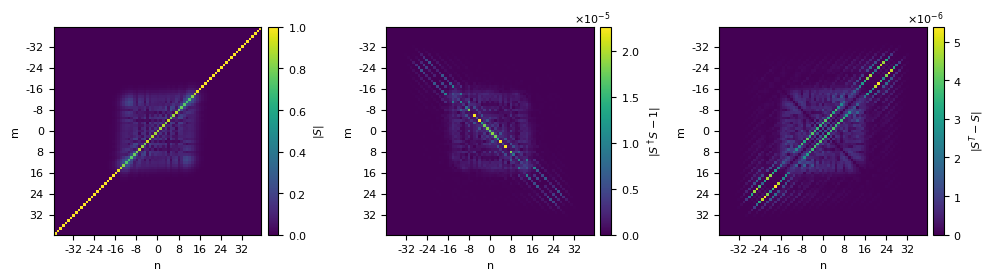

In [19]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

# Random medium

In [20]:
scatPos, scatRad = DrawRandPositions(params, 0.00825, numScat=20, radMax=0.8*pmlRad)
# Find random positions for 20 scatterers with radius 0.00825 and maximum radial distance to the center of 0.8*pmlRad
scatNr = 1.44*np.ones(len(scatRad))

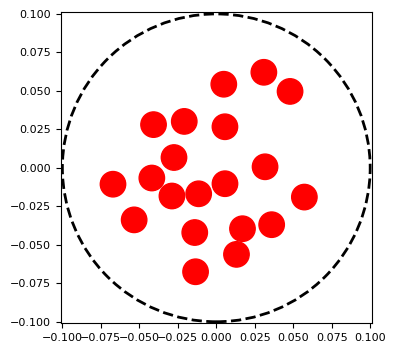

In [21]:
PlotScatteringConfiguration(params, scatPos, scatRad, widthInches=4, showAxis=True)

In [22]:
CreateGeometry(params, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False)

In [23]:
S = CalcSMat(params)

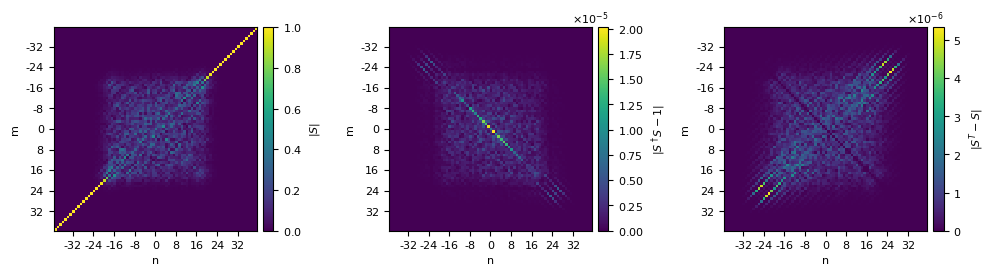

In [24]:
plt.rcdefaults()
plt.rcParams.update({'font.size': 8})

widthInches = 5

fig, axs = plt.subplots(1, 3, figsize=(2*widthInches,widthInches))

im = axs[0].imshow(np.abs(S), interpolation='None')
divider = make_axes_locatable(axs[0])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S|$')
cax.ticklabel_format(useMathText=True)

im = axs[1].imshow(np.abs(S.conj().T@S-np.eye(2*nIn+1)), interpolation='None')
divider = make_axes_locatable(axs[1])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^\dagger S - 1|$')
cax.ticklabel_format(useMathText=True)

im = axs[2].imshow(np.abs(S.T - S), interpolation='None')
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", "5%", pad="3%")
fig.colorbar(im, cax=cax, label=r'$|S^T - S|$')
cax.ticklabel_format(useMathText=True)

for i in range(3):
    axs[i].set_xticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_xticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_yticks(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8)))) 
    axs[i].set_yticklabels(np.hstack((np.arange(7,nIn-1,8), np.array([nIn]), np.arange(nIn+8,2*nIn+1,8))) - nIn)
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('m', rotation=90)
    
plt.tight_layout()
plt.show()

# Force, metallic circle

In [25]:
scatPos = np.array([[pmlRad/2], [0]])
scatRad = np.array([0.00825])
scatNr = np.array([1e6])
scatShape = ['circ']

In [26]:
CreateGeometry(params, scatShape=scatShape, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False)
S = CalcSMat(params, msgOutput=False)

Fix the solid angle through which waves can enter the system

In [28]:
angle = np.pi/2

Number of entries in the S matrix and GWS operator that are relevant for a giveen solid angle
An entry with an index above lowCut or below highCut is set to zero

In [29]:
lowCut = int(nIn//(2*np.pi/angle) + 1)
highCut = int(2*nIn-nIn//(2*np.pi/angle))

Compute the GWS operator

In [30]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='abs', deriv=False, restrict=True, angle=angle)
Qxevals = np.real(Qxevals[:lowCut+2*nIn+1-highCut]) # Remove all entries equal to zero

Compute the forces acting on the target for all eigenstates of the GWS operator

In [24]:
pphwl = 20
npts = int(ceil(2*scatRad[0]*k*pphwl))
F = CalcForce(params, Qxcoefs, range(lowCut+2*nIn+1-highCut), scatPos[:,0], npts, scatRad=scatRad[0], 
              scatShape='circle', d=1e-4)
Fx = F[:,0]

Check that they are in a linear relationship with the eigenvalues of $Q_x$

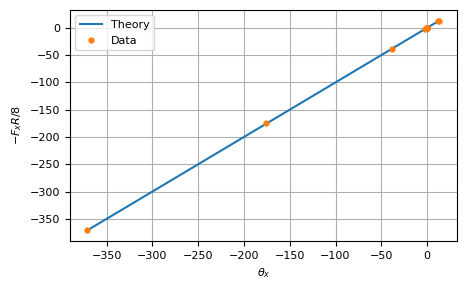

R = 0.9999970
Fit:      0.9975 x + 0.0259
Analytic: 1.0000 x 
F_push_theory / F_push_sim = 1.001
F_pull_theory / F_pull_sim = 1.014


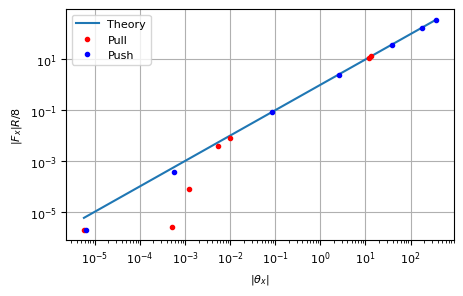

In [25]:
z = np.polyfit(Qxevals, -scatRad[0]*Fx/8, 1)
p = np.poly1d(z)

plt.figure(figsize=(5,3))
plt.plot(np.sort(Qxevals), np.sort(Qxevals), label='Theory')
plt.plot(Qxevals, -scatRad[0]*Fx/8, '.', label='Data', ms=7)
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$-F_x R / 8$')
plt.legend()
plt.grid()
plt.show()

print('R = %.7f' %np.corrcoef(Qxevals, -scatRad[0]*Fx/8)[0,1])
print('Fit:      %.4f x + %.4f'%(z[0], z[1]))
print('Analytic: %.4f x ' %(1))
print('F_push_theory / F_push_sim = %.3f' %(Qxevals[np.argmin(Qxevals)]/(-scatRad[0]*Fx[np.argmin(Qxevals)]/8)))
print('F_pull_theory / F_pull_sim = %.3f' %(Qxevals[np.argmax(Qxevals)]/(-scatRad[0]*Fx[np.argmax(Qxevals)]/8)))

plt.figure(figsize=(5,3))
plt.plot(np.sort(np.abs(Qxevals)), np.sort(np.abs(Qxevals)), label='Theory')
plt.plot(Qxevals[Qxevals>0], -scatRad[0]*Fx[Qxevals>0]/8, '.', c='r', label='Pull')
plt.plot(-Qxevals[Qxevals<0], scatRad[0]*Fx[Qxevals<0]/8, '.', c='b', label='Push')
plt.xlabel(r'$|\theta_x|$')
plt.ylabel(r'$|F_x| R / 8$')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1,1e3)
#plt.xlim(1,1e3)
plt.legend()
plt.grid()
plt.show()

# Force, metallic triangle

In [31]:
scatPos = np.array([[pmlRad/2], [0]])
polyPts = np.array([[-lam, 0, 0], [0, -lam/2, lam/2]]) # coordinates of the triangle's corners relative to scatPos
scatNr = np.array([1e6])
scatShape = ['poly']

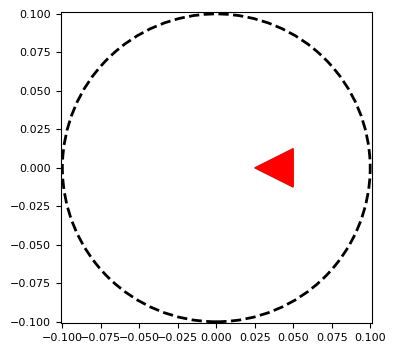

In [32]:
PlotScatteringConfiguration(params, scatPos, scatRad, scatShape=scatShape, polyPts=polyPts, widthInches=4)

In [33]:
CreateGeometry(params, scatPos=scatPos, scatNr=scatNr, scatShape=scatShape, polyPts=polyPts, msgOutput=False)
S = CalcSMat(params, msgOutput=False)

In [34]:
Qxevals, Qxcoefs, Qx = CalcGWSOperator(params, S, 0, sort='abs', deriv=False, restrict=True, angle=angle)
Qxevals = np.real(Qxevals[:lowCut+2*nIn+1-highCut])

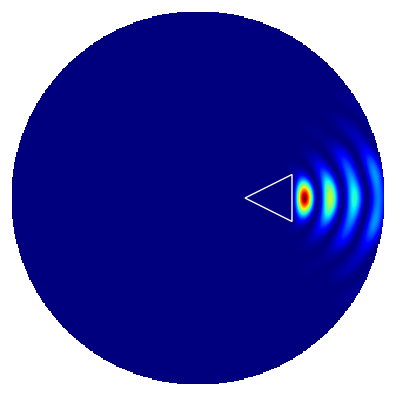

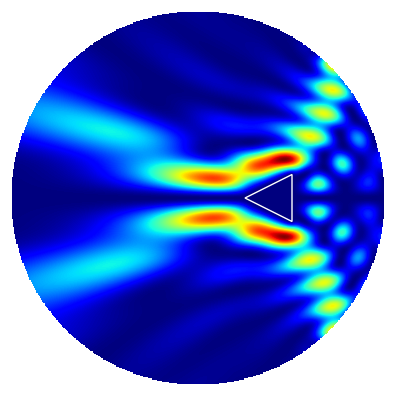

In [35]:
PlotStates(params, Qxcoefs, [np.argmin(Qxevals),np.argmax(Qxevals)], scatPos=scatPos, scatShape=scatShape, 
           polyPts=polyPts, widthInches=4)

In [36]:
F = CalcForce(params, Qxcoefs, range(lowCut+2*nIn+1-highCut), scatPos[:,0], 100, polyPts=polyPts, scatShape='poly', 
              d=1e-8)
Fx = F[:,0]

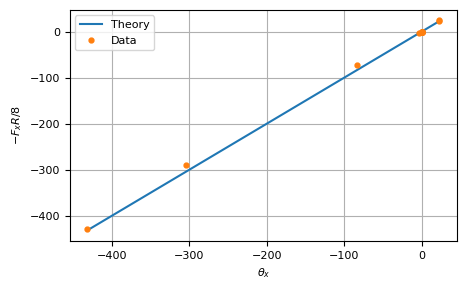

R = 0.9996459
Fit:      0.9782 x + 0.7767
Analytic: 1.0000 x 
F_push_theory / F_push_sim = 1.008
F_pull_theory / F_pull_sim = 0.944


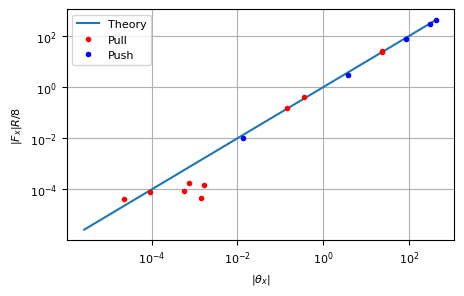

In [37]:
z = np.polyfit(Qxevals, -Fx/8, 1)
p = np.poly1d(z)

plt.figure(figsize=(5,3))
plt.plot(np.sort(Qxevals), np.sort(Qxevals), label='Theory')
plt.plot(Qxevals, -Fx/8, '.', label='Data', ms=7)
plt.xlabel(r'$\theta_x$')
plt.ylabel(r'$-F_x R / 8$')
plt.legend()
plt.grid()
plt.show()

print('R = %.7f' %np.corrcoef(Qxevals, -Fx/8)[0,1])
print('Fit:      %.4f x + %.4f'%(z[0], z[1]))
print('Analytic: %.4f x ' %(1))
print('F_push_theory / F_push_sim = %.3f' %(Qxevals[np.argmin(Qxevals)]/(-Fx[np.argmin(Qxevals)]/8)))
print('F_pull_theory / F_pull_sim = %.3f' %(Qxevals[np.argmax(Qxevals)]/(-Fx[np.argmax(Qxevals)]/8)))

plt.figure(figsize=(5,3))
plt.plot(np.sort(np.abs(Qxevals)), np.sort(np.abs(Qxevals)), label='Theory')
plt.plot(Qxevals[Qxevals>0], -Fx[Qxevals>0]/8, '.', c='r', label='Pull')
plt.plot(-Qxevals[Qxevals<0], Fx[Qxevals<0]/8, '.', c='b', label='Push')
plt.xlabel(r'$|\theta_x|$')
plt.ylabel(r'$|F_x| R / 8$')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1,1e3)
#plt.xlim(1,1e3)
plt.legend()
plt.grid()
plt.show()

# Shift

Check that the scattering matrix of a target shifted by some amount can also be computed using an unitary translation operator

In [38]:
scatPos = np.array([[0], [0]])
scatRad = np.array([0.00825])
scatNr = np.array([1e6])
scatShape = ['circ']
shifts = np.linspace(0,pmlRad-2*scatRad[0],11)
print(shifts/lam)

[0.    0.334 0.668 1.002 1.336 1.67  2.004 2.338 2.672 3.006 3.34 ]


Compute the shifted scattering matrices by shifting the target

In [39]:
S = np.zeros((2*nOut+1,2*nIn+1,len(shifts)), dtype=complex)
for i in range(len(shifts)):
    CreateGeometry(params, scatShape=scatShape, scatPos=scatPos, scatRad=scatRad, scatNr=scatNr, msgOutput=False, 
                   shiftLong=shifts[i])
    S[:,:,i] = CalcSMat(params)
    print('%d/%d' %(i+1,len(shifts)), end='\r')

In [40]:
kx = CalcKxInOperator(params) # Compute K_x^{in}

Compute the shifted (translated) scattering matrix by unitary transformation

In [41]:
S_trans = np.zeros((2*nOut+1,2*nIn+1,len(shifts)), dtype=complex)
for i in range(len(shifts)):
    S_trans[:,:,i] = sp.linalg.expm(-1.j*kx*shifts[i])@S[:,:,0]@sp.linalg.expm(1.j*kx*shifts[i])

Check that this gives the same result (up to numerical error)

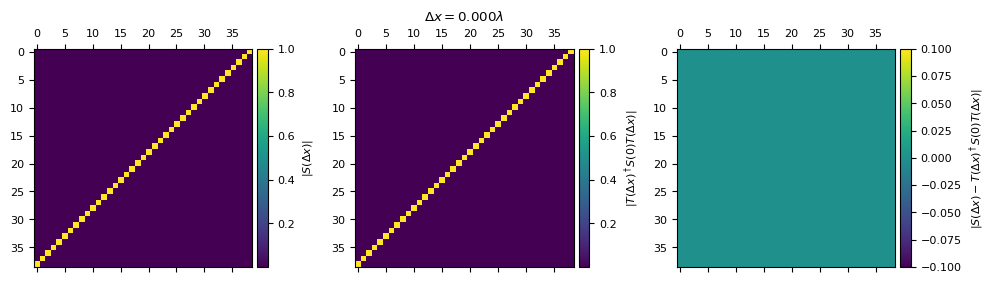

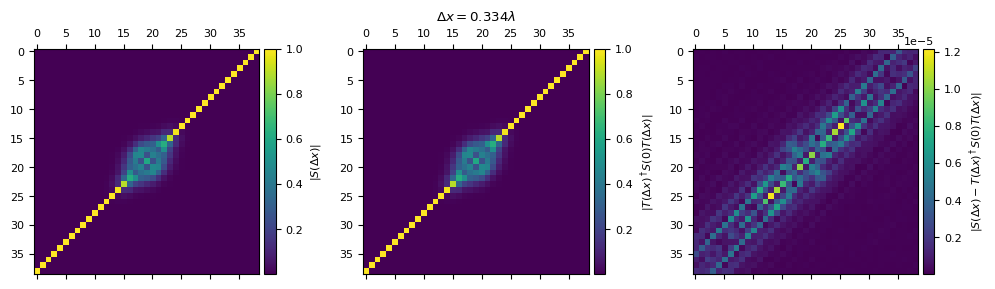

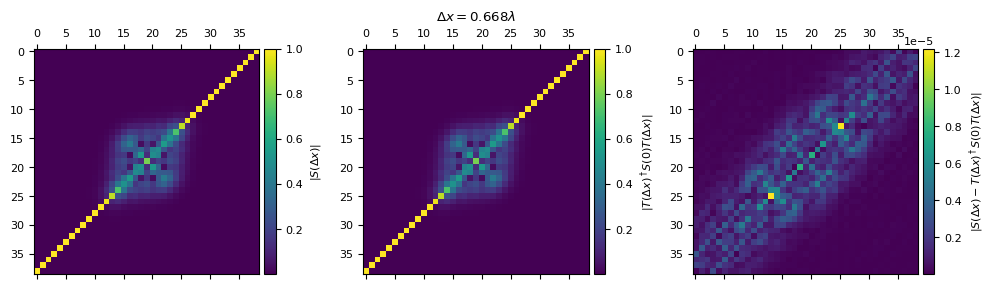

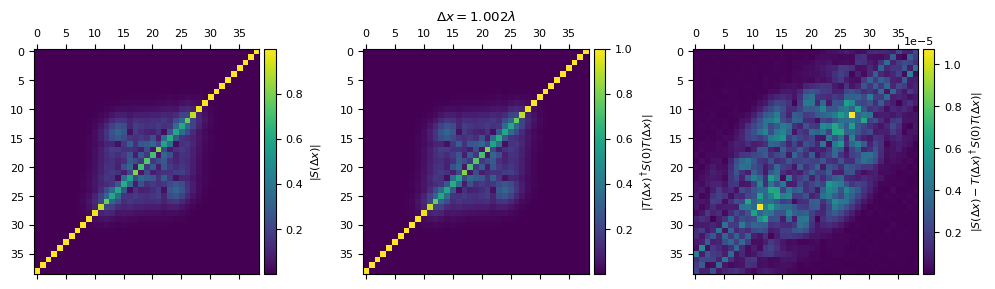

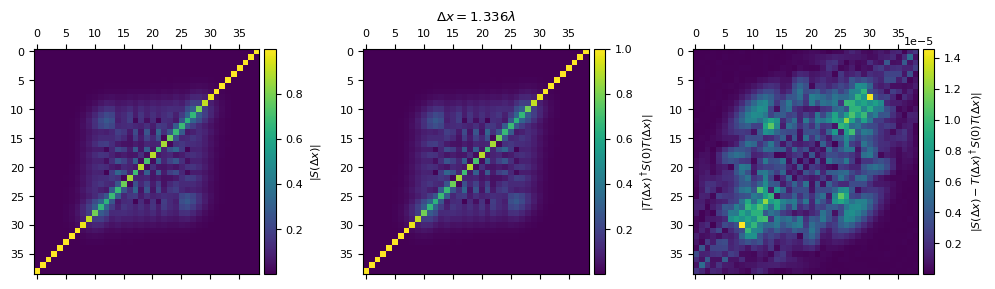

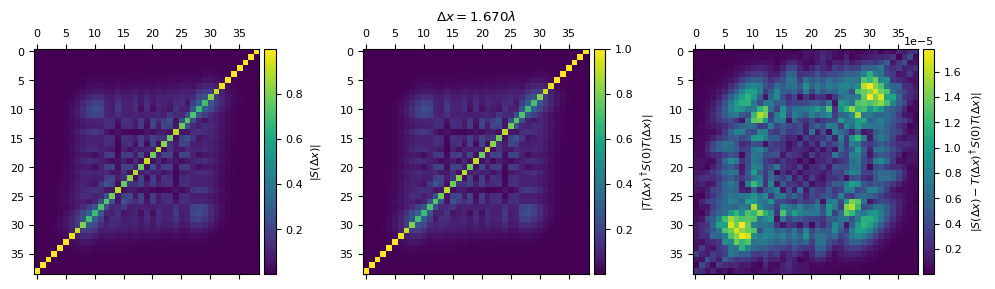

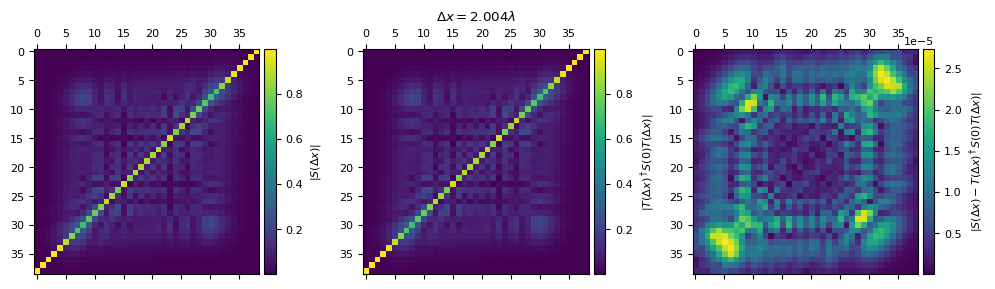

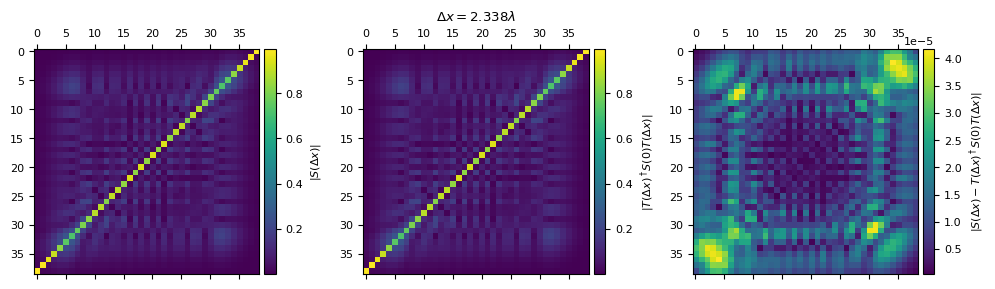

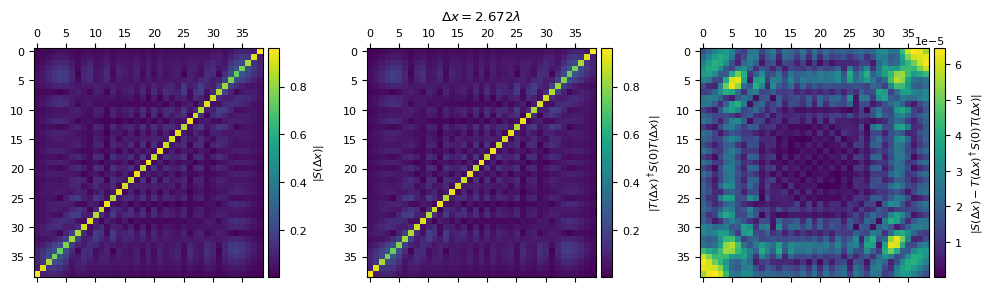

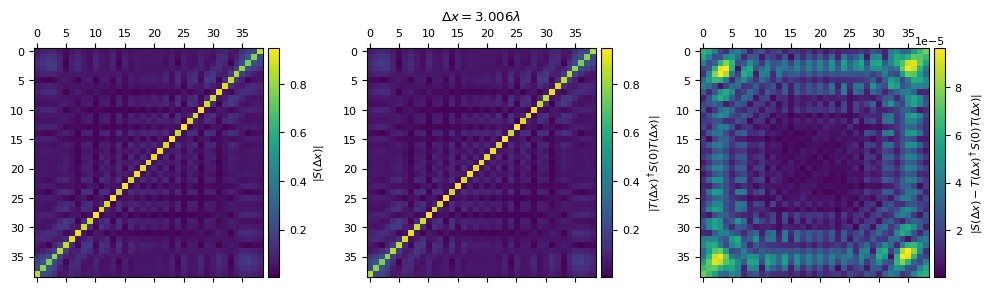

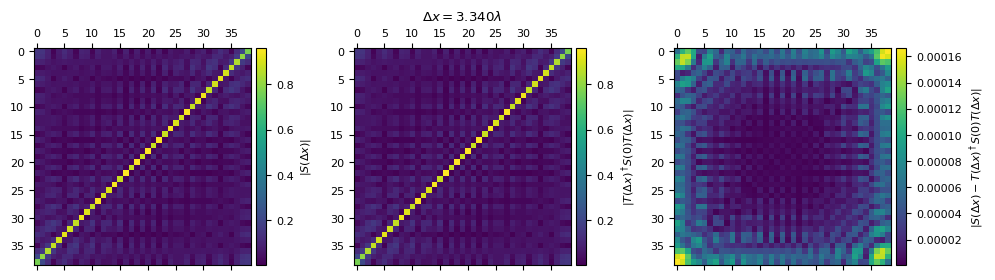

In [42]:
for i in range(len(shifts)):
    fig, ax = plt.subplots(ncols=3, figsize=(10,4))
    ax[1].set_title(r'$\Delta x = %.3f \lambda$' %(shifts[i]/lam))
    im1 = ax[0].matshow(np.abs(S[20:-20,20:-20,i]))
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical', label=r'$|S(\Delta x)|$')
    im2 = ax[1].matshow(np.abs(S_trans[20:-20,20:-20,i]))
    divider = make_axes_locatable(ax[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical', label=r'$|T(\Delta x)^\dagger S(0) T(\Delta x)|$')
    im3 = ax[2].matshow(np.abs(S[20:-20,20:-20,i]-S_trans[20:-20,20:-20,i]))
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical', label=r'$|S(\Delta x)-T(\Delta x)^\dagger S(0) T(\Delta x)|$')
    plt.tight_layout()
    plt.show()